# Meta Kaggle EDA

This notebook contains Exploratory Data Analysis (EDA) to understand the content of the Meta Kaggle dataset (in its 15 July 2020 version).

The output of this preliminary analyisis is a `.csv` file with download URLs for Kaggle notebooks divided by their authors' expertise level.

**Import statements**

In [22]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from IPython.display import Image

**Global variables**

In [2]:
DATASET_PATH = '../Kaggle data/MetaKaggle20200715'

## Utility functions

In [3]:
def summarize_cleaning_step(current_df_name, current_df, previous_df, original_df):
    """
    Prints the number of items after the current cleaning step and
    the percentages of items saved by the cleaning step with respect to
    the dataframe before its application and the original dataset.
    """
    current_df_len = current_df.shape[0]
    print('Number of {}: {:,d}'.format(current_df_name, current_df_len))
    
    number_of_removed_kernels = previous_df.shape[0] - current_df_len
    print('Number of kernels removed from the previous cleaning step: {:,d}'.format(number_of_removed_kernels))

    percentage_over_cleaned = current_df_len * 100 / previous_df.shape[0] 
    print('Percentage over the cleaned set: {:.2f}%'.format(percentage_over_cleaned))

    percentage_over_original = current_df_len * 100 / original_df.shape[0] 
    print('Percentage over the original set: {:.2f}%'.format(percentage_over_original))

## Data import

In [4]:
%%time

# KERNELS
dates_to_be_parsed = [
    'CreationDate',
    'EvaluationDate',
    'MadePublicDate',
    'MedalAwardDate'
]
%time kernels = pd.read_csv(os.path.join(DATASET_PATH, 'Kernels.csv'), parse_dates=dates_to_be_parsed)

# KERNEL VERSIONS
%time kernelVersions = pd.read_csv(os.path.join(DATASET_PATH, 'KernelVersions.csv'), parse_dates=['CreationDate'])
kernelVersions = kernelVersions[[
    'Id',
    'ScriptId',
    'ScriptLanguageId',
    'AuthorUserId',  # Is the author consistent with the source script?
    'CreationDate',  # How often the creation date is different from the source script's one?
    'VersionNumber',
    'TotalLines',  # Might this be a threshold? What's the distribution?
    'TotalVotes'  # How is this variable related to the source script's correspondent?
]]

# KERNEL LANGUAGES
%time kernelLanguages = pd.read_csv(os.path.join(DATASET_PATH, 'KernelLanguages.csv'))

# USERS
%time users = pd.read_csv(os.path.join(DATASET_PATH, 'Users.csv'), parse_dates=['RegisterDate'])

# USER ACHIEVEMENTS
dates_to_be_parsed = [
    'TierAchievementDate',
]
%time userAchievements = pd.read_csv(os.path.join(DATASET_PATH, 'UserAchievements.csv'), parse_dates=dates_to_be_parsed)

CPU times: user 2min 11s, sys: 904 ms, total: 2min 12s
Wall time: 2min 16s
CPU times: user 7min 38s, sys: 3.06 s, total: 7min 41s
Wall time: 7min 45s
CPU times: user 3 ms, sys: 1.58 ms, total: 4.58 ms
Wall time: 14.4 ms
CPU times: user 8min 32s, sys: 3.87 s, total: 8min 36s
Wall time: 8min 54s
CPU times: user 17min 15s, sys: 8.5 s, total: 17min 23s
Wall time: 17min 52s
CPU times: user 35min 38s, sys: 16.5 s, total: 35min 54s
Wall time: 36min 49s


## Filter "Python Jupyter Notebooks"

I want to filter Kaggle kernels in order to select only Python Jupyter Notebooks.

To begin, I need to join the tables that carry useful information for this first filtering step.

Therefore I join `Kernels.csv` with `KernelVersions.csv`

In [5]:
kernels_currentVersion = pd.merge(
    kernels, kernelVersions,
    left_on='CurrentKernelVersionId', right_on='Id',
    suffixes=('', '_currentVersion'))

summarize_cleaning_step('kernels with current version info', kernels_currentVersion, kernels, kernels)

Number of kernels with current version info: 332,143
Number of kernels removed from the previous cleaning step: 43,049
Percentage over the cleaned set: 88.53%
Percentage over the original set: 88.53%


And then i join the result with `KernelLanguages.csv`.

In [6]:
kernel_currentVersion_language = pd.merge(
    kernels_currentVersion, kernelLanguages,
    left_on='ScriptLanguageId', right_on='Id',
    suffixes=('', '_language'))

summarize_cleaning_step('kernels with language info', kernel_currentVersion_language, kernels_currentVersion, kernels)

Number of kernels with language info: 331,408
Number of kernels removed from the previous cleaning step: 735
Percentage over the cleaned set: 99.78%
Percentage over the original set: 88.33%


### Kernel Languages

So far, I have filtered out kernels without info about their current version and language. Now I can give a closer look at kernel languages.

Each *kernel version* is associated with one of these *kernel languages*.

In [7]:
kernelLanguages

,Id,Name,DisplayName,IsNotebook
0,1,R,R,False
1,2,Python,Python,False
2,5,RMarkdown,R,False
3,8,IPython Notebook,Python,True
4,9,IPython Notebook HTML,Python,False
5,12,R Notebook HTML,R,False
6,13,R Notebook,R,True
7,14,Python Script - Interactive,Python,True
8,15,R Script - Interactive,R,True
9,16,RMarkdown - Interactive,R,True


I want to focus on Python kernels, so I filter the table accordingly.

In [8]:
kernelLanguages[kernelLanguages['DisplayName']=='Python']

,Id,Name,DisplayName,IsNotebook
1,2,Python,Python,False
3,8,IPython Notebook,Python,True
4,9,IPython Notebook HTML,Python,False
7,14,Python Script - Interactive,Python,True


To understand the differences between these types of Python kernels on Kaggle, I need to manually inspect a little sample for each of them; I need to retrieve them by their links.

Each kernel link on Kaggle is formed with the *author's username* and the kernel's *current slug*.

#### Should I consider the **author of the kernel** or the **author of the kernel version**?

What's the correct meaning of kernel "author" in Kaggle?

Is there any difference between a kernel's author and one of its versions author?

In [9]:
kernels_currentVersion[
    kernels_currentVersion['AuthorUserId'] != kernels_currentVersion['AuthorUserId_currentVersion']].shape[0]

1126

Yes, evidently there is.

So I guess that I should use the author ID from the KernelVersions table: he must be the actual author of the notebook that I will download via the API/donwload URL.

With this assuption in mind, I further join the dataframe resulting from the previous join operations with `Users.csv`.

In [10]:
kernel_currentVersion_language_author = pd.merge(
    kernel_currentVersion_language, users,
    left_on='AuthorUserId_currentVersion', right_on='Id',
    suffixes=('', '_author'))

summarize_cleaning_step('kernels with language and author info', kernel_currentVersion_language_author, kernel_currentVersion_language, kernels)

Number of kernels with language and author info: 327,550
Number of kernels removed from the previous cleaning step: 3,858
Percentage over the cleaned set: 98.84%
Percentage over the original set: 87.30%


Now I am able to produce URL lists for kernels belonging to each language in the table (i.e., for python kernels of each of the four types listed in the last table).

I will use these links to retrieve the corresponding kaggle.com pages and understand - by a manual qualitative inspection - the nature such kernels.

In [11]:
#  Python
python = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'Python'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# IPython Notebook
ipython_notebook = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'IPython Notebook'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# IPython Notebook HTML
ipython_notebook_html = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'IPython Notebook HTML'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

# Python Script - Interactive
python_script_interactive = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'Python Script - Interactive'][['UserName', 'CurrentUrlSlug', 'CreationDate_currentVersion']]

python_kernels = {
    'Python': python,
    'IPython Notebook': ipython_notebook,
    'IPython Notebook HTML': ipython_notebook_html,
    'Python Script - Interactive': python_script_interactive
}

for kernel in python_kernels:
    
    print('Number of kernels of type "{}": {:,d}'.format(kernel, python_kernels[kernel].shape[0]))
    
    python_kernels[kernel].sort_values('CreationDate_currentVersion', ascending=False)
    
    python_kernels[kernel]['url'] = 'https://www.kaggle.com/' + python_kernels[kernel]['UserName'] + '/' + python_kernels[kernel]['CurrentUrlSlug']
    python_kernels[kernel]['slug'] = python_kernels[kernel]['UserName'] + '/' + python_kernels[kernel]['CurrentUrlSlug']
    
    python_kernels[kernel]['url'].to_csv('notebook_output/{} - URLs.csv'.format(kernel), header=False, index=False)
    python_kernels[kernel]['slug'].to_csv('notebook_output/{} - slugs.csv'.format(kernel), header=False, index=False)
    

Number of kernels of type "Python": 21,503
Number of kernels of type "IPython Notebook": 49,414
Number of kernels of type "IPython Notebook HTML": 224,336
Number of kernels of type "Python Script - Interactive": 15


#### Manual inspection of the different types of Kaggle Python kernels

I performed a manual, qualitative inspection of a sample of kernels from each python language category.

I discovered what follows.

- `Python` kernels are actual python scripts (and not Jupyter Notebooks).
- `IPython Notebook` kernels are not available anymore (for the most part).
- `IPython Notebook HTML` kernels are the HTML version of Jupyter Notebook files; they must have been produced using `nbconvert`; however, with the help of the Kaggle official API, it is possibile to download the source `.ipynb` notebook (without retrospective data, i.e., output cells). It is also possibile to downalod full `.ipynb` files (with retrospective data), using the following pattern to form download URLs: `https://www.kaggle.com/kernels/scriptcontent/<CurrentKernelVersionId>/download`
- `Python Script - Interactive` kernels are just 15 and are not available anymore.

##### A further justification

`IPython Notebook` and `Python Script - Interactive` kernels might be old language tags that are not used anymore. I try to prove that by querying the `CreationDate` field from the `KernelVersions` table.

In [12]:
ipython_notebook['CreationDate_currentVersion'].describe()

count                   49414
unique                  49322
top       2017-01-10 18:20:52
freq                        3
first     2015-08-27 04:17:45
last      2018-04-18 17:30:49
Name: CreationDate_currentVersion, dtype: object

In [13]:
python_script_interactive['CreationDate_currentVersion'].describe()

count                      15
unique                     15
top       2018-02-25 11:22:21
freq                        1
first     2017-10-23 14:56:15
last      2018-04-13 02:14:54
Name: CreationDate_currentVersion, dtype: object

In both cases, kenrels of these kinds seem to have been dismissed during April 2018.

In [14]:
python['CreationDate_currentVersion'].describe()

count                   21503
unique                  21501
top       2016-06-14 06:46:08
freq                        2
first     2015-04-03 17:00:18
last      2020-07-14 15:51:11
Name: CreationDate_currentVersion, dtype: object

In [15]:
ipython_notebook_html['CreationDate_currentVersion'].describe()

count                  224336
unique                 223859
top       2018-10-11 20:06:49
freq                        8
first     2015-09-15 22:01:57
last      2020-07-15 00:03:03
Name: CreationDate_currentVersion, dtype: object

On the contrary, the other two types of kernel seem to span the whole period of time covered by the dataset.

I can finally filter the dataset and take only Python Jupyter Notebooks.

In [16]:
df = kernel_currentVersion_language_author[
    kernel_currentVersion_language_author['Name'] == 'IPython Notebook HTML']

summarize_cleaning_step('Python Jupyter Notebook kernels', df,
                        kernel_currentVersion_language_author, kernels)

Number of Python Jupyter Notebook kernels: 224,336
Number of kernels removed from the previous cleaning step: 103,214
Percentage over the cleaned set: 68.49%
Percentage over the original set: 59.79%


## Filter notebooks by expert users

### User Achievements

First of all, I want to understand how to separate Kaggle beginners from experienced users.

In [17]:
userAchievements.AchievementType.value_counts()

Discussion      3570152
Competitions    3570152
Scripts         3570152
Name: AchievementType, dtype: int64

In [18]:
userAchievements.groupby('UserId')['Id'].count().value_counts()

3    3570152
Name: Id, dtype: int64

Each user is associated with 3 rows in the table `UserAchievements.csv`. Each of these rows describes the achievement of that user in one of the four *categories of expertise* mentioned in the [Kaggle Documentation](https://www.kaggle.com/progression).

Of such 4 categories of expertise (`Competitions`, `Notebooks`, `Datasets`, and `Discussion`), only 3 are covered in the Meta Kaggle dataset: the `Datasets` category is missing. 

In `UserAchievements.csv`, the category of expertise is defined by the field `AchievementType`.

I will now try to understand how users are distributed along the possibile *expertise tiers*: `Novice`, `Contributor`, `Expert`, `Master`, and `Grandmaster`.

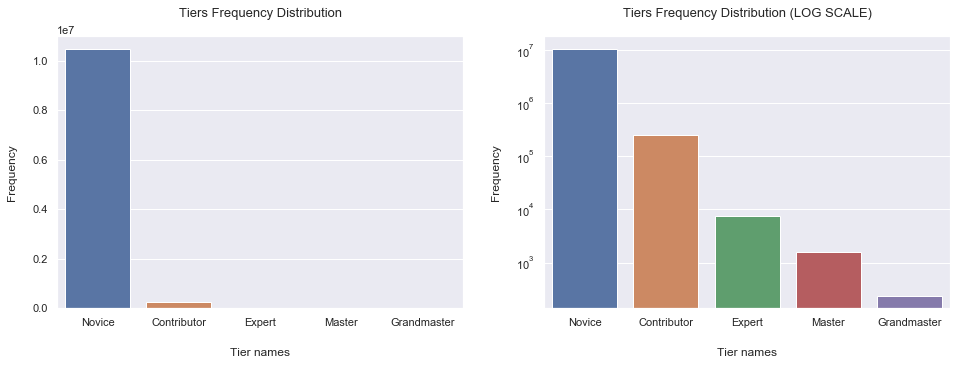

In [19]:
tiers = userAchievements.Tier.value_counts()
tiers_labels = [
    'Novice',
    'Contributor',
    'Expert',
    'Master',
    'Grandmaster'
]

plt.subplot(121)
sns.barplot(tiers_labels, tiers.values)
plt.title('Tiers Frequency Distribution', fontsize=13, pad=20)
plt.xlabel('Tier names', labelpad=20)
plt.ylabel('Frequency', labelpad=15)


plt.subplot(122)
sns.barplot(tiers_labels, tiers.values, log=True)
plt.title('Tiers Frequency Distribution (LOG SCALE)', fontsize=13, pad=20)
plt.xlabel('Tier names', labelpad=20)
plt.ylabel('Frequency', labelpad=15)

plt.gcf().set_size_inches(16,5)

In [20]:
tiers_scripts = userAchievements.loc[userAchievements['AchievementType'] == 'Scripts', ['Tier']].Tier.value_counts()
tiers_competitions = userAchievements.loc[userAchievements['AchievementType'] == 'Competitions', ['Tier']].Tier.value_counts()
tiers_discussions = userAchievements.loc[userAchievements['AchievementType'] == 'Discussion', ['Tier']].Tier.value_counts()

tiers_summary_df_map = {
    'Tier name':tiers_labels,
    'Scripts': tiers_scripts,
    'Competitions': tiers_competitions,
    'Discussions': tiers_discussions,
    'TOTAL frequency': tiers
}
tiers_summary_df = pd.DataFrame(tiers_summary_df_map)
tiers_summary_df.set_index('Tier name')

,Scripts,Competitions,Discussions,TOTAL frequency
Tier name,,,,
Novice,3484484,3484484,3484484,10453452
Contributor,84675,78370,84694,247739
Expert,867,5670,893,7430
Master,99,1441,58,1598
Grandmaster,27,187,23,237


I decide to focus my analyses on notebooks by users that are at least in the `Expert` tier in at least one of the categories of expertise available in Meta Kaggle. So I further filter out rows from this dataset according to this criterion.

### Experienced authors

To begin this new filtering step, I need a list of all the experienced authors in Kaggle.

I further define the concept of **experienced author** as follows:

> I consider an **experienced author** a Kaggle user that is at least in the `Expert` tier in at least one of the *categories of experise* available in Meta Kaggle and that has been in this condition for at least the last six months.

Indeed I don't want to analyze notebooks from authors that have just reached the `Expert` tier.

In [24]:

six_months_ago

datetime.datetime(2020, 1, 17, 17, 31, 44, 10097)

In [25]:
six_months_ago = datetime.now() + relativedelta(months=-6)
expert_achievements = userAchievements[
    (userAchievements['Tier'] > 1) & (userAchievements['TierAchievementDate'] < six_months_ago)]
experts = expert_achievements.UserId.unique()
experts.shape[0]

7185

This is the number of users that are in the `Expert`, `Master` or `Grandmaster` tier in one of the three categories of expertise: `Competition`, `Notebook`, `Discussion` since more than six months.

I can now filter notebooks by these knowledgeable authors.

I want to take notebooks whose latest version has been created after their author has been promoted to (at least) the expert tier in some category of expertise.

In [40]:
%%time
notebooks_by_experts = df[df.apply(
    lambda x: not expert_achievements[
        (expert_achievements['UserId'] == x['AuthorUserId_currentVersion']) &
        (expert_achievements['TierAchievementDate'] < x['CreationDate_currentVersion'])
    ].empty
, axis=1)]

notebooks_by_beginners = df[~df.index.isin(notebooks_by_experts.index)]

CPU times: user 6min 6s, sys: 2.83 s, total: 6min 9s
Wall time: 6min 21s


In [44]:
summarize_cleaning_step('Jupyter Notebooks from experts', notebooks_by_experts, df, kernels)

Number of Jupyter Notebooks from experts: 11,592
Number of kernels removed from the previous cleaning step: 212,744
Percentage over the cleaned set: 5.17%
Percentage over the original set: 3.09%


In [45]:
print("# of notebooks to be partitioned: {:,}".format(df.shape[0]))
print("# of notebooks by esperts: {:,}".format(notebooks_by_experts.shape[0]))
print("# of notebooks by beginners: {:,}".format(notebooks_by_beginners.shape[0]))

# of notebooks to be partitioned: 224,336
# of notebooks by esperts: 11,592
# of notebooks by beginners: 212,744


### Visualization of the filtering steps

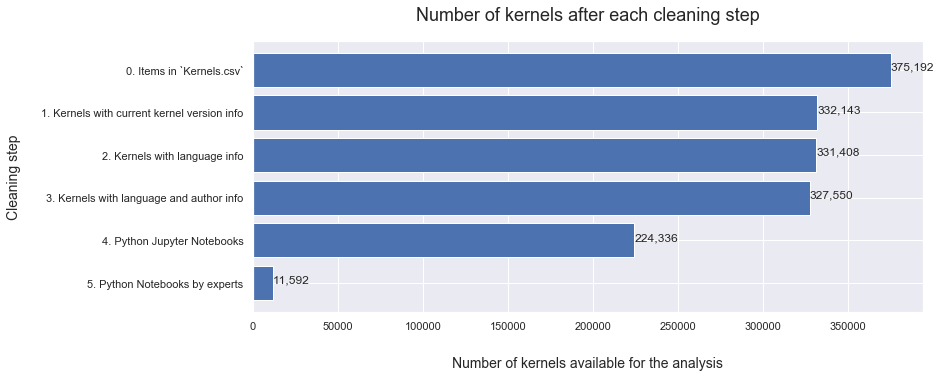

In [46]:
steps = {
    '5. Python Notebooks by experts': notebooks_by_experts.shape[0],
    '4. Python Jupyter Notebooks': df.shape[0],
    '3. Kernels with language and author info': kernel_currentVersion_language_author.shape[0],
    '2. Kernels with language info': kernel_currentVersion_language.shape[0],
    '1. Kernels with current kernel version info': kernels_currentVersion.shape[0],
    '0. Items in `Kernels.csv`': kernels.shape[0]
}

plt.barh(y=list(steps.keys()), width=list(steps.values()))
for index, value in enumerate(list(steps.values())):
    plt.text(value, index, '{:,d}'.format(value))
    
plt.title("Number of kernels after each cleaning step", fontsize=18, pad=20)
plt.xlabel("Number of kernels available for the analysis", fontsize=14, labelpad=25)
plt.ylabel("Cleaning step", fontsize=14, labelpad=20)
    
plt.gcf().set_size_inches(12,5)

## Further minor filtering operations

### CurrentUrlSlug

To download the notebooks via the API I need the `CurrentUrlSlug`.
I make sure that every kernel in the dataset has a `CurrentUrlSlug`.

In [47]:
notebooks_by_experts[notebooks_by_experts['CurrentUrlSlug'].isna()].shape[0]

0

Every notebook in the dataset has a `CurrentUrlSlug`.

### IsProjectLanguageTemplate

After a manual inspection, I realized that kernels marked with the flag `IsProjectLanguageTemplate` are not to be included in the analysis. They are, as the name of the flag suggests, just templates, maybe provided to participants in the beginning of challenges.

In [48]:
notebooks_by_experts[notebooks_by_experts['IsProjectLanguageTemplate']].shape[0]

0

After the filtering operations above, no *"project language template"* has survived, therefore the cleaning operations are completed.

## Output filtered URL/slug list

In [49]:
notebooks_by_experts.columns

Index(['Id', 'AuthorUserId', 'CurrentKernelVersionId',
       'ForkParentKernelVersionId', 'ForumTopicId', 'FirstKernelVersionId',
       'CreationDate', 'EvaluationDate', 'MadePublicDate',
       'IsProjectLanguageTemplate', 'CurrentUrlSlug', 'Medal',
       'MedalAwardDate', 'TotalViews', 'TotalComments', 'TotalVotes',
       'Id_currentVersion', 'ScriptId', 'ScriptLanguageId',
       'AuthorUserId_currentVersion', 'CreationDate_currentVersion',
       'VersionNumber', 'TotalLines', 'TotalVotes_currentVersion',
       'Id_language', 'Name', 'DisplayName', 'IsNotebook', 'Id_author',
       'UserName', 'DisplayName_author', 'RegisterDate', 'PerformanceTier'],
      dtype='object')

In [50]:
notebooks_by_experts['url'] = 'https://www.kaggle.com/' + notebooks_by_experts['UserName'] + '/' + notebooks_by_experts['CurrentUrlSlug']
notebooks_by_experts['full_download_url'] = 'https://www.kaggle.com/kernels/scriptcontent/' + notebooks_by_experts['CurrentKernelVersionId'].astype('int64').astype('str') + '/download'
notebooks_by_experts['slug'] = notebooks_by_experts['UserName'] + '/' + notebooks_by_experts['CurrentUrlSlug']

notebooks_by_beginners['url'] = 'https://www.kaggle.com/' + notebooks_by_beginners['UserName'] + '/' + notebooks_by_beginners['CurrentUrlSlug']
notebooks_by_beginners['full_download_url'] = 'https://www.kaggle.com/kernels/scriptcontent/' + notebooks_by_beginners['CurrentKernelVersionId'].astype('int64').astype('str') + '/download'
notebooks_by_beginners['slug'] = notebooks_by_beginners['UserName'] + '/' + notebooks_by_beginners['CurrentUrlSlug']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

### URLs

In [51]:
notebooks_by_experts['url'].to_csv('notebook_output/Notebooks by experts - URLs.csv', header=False, index=False)
notebooks_by_beginners['url'].to_csv('notebook_output/Notebooks by beginners - URLs.csv', header=False, index=False)

### Slugs

In [52]:
notebooks_by_experts['slug'].to_csv('notebook_output/Notebooks by experts - slugs.csv', header=False, index=False)
notebooks_by_beginners['slug'].to_csv('notebook_output/Notebooks by beginners - slugs.csv', header=False, index=False)

### Full download URLs

In [53]:
notebooks_by_experts.to_csv('notebook_output/Notebooks by experts - full download URLs.csv', columns=['slug', 'full_download_url'], header=['slug', 'url'], index=False)
notebooks_by_beginners.to_csv('notebook_output/Notebooks by beginners - full download URLs.csv', columns=['slug', 'full_download_url'], header=['slug', 'url'], index=False)

# Further analyses on this dataset

## Distribution of notebooks creation dates

In [54]:
notebooks_by_experts.CreationDate_currentVersion.describe()

count                   11592
unique                  11591
top       2019-12-13 17:13:20
freq                        2
first     2016-07-15 04:41:15
last      2020-07-14 23:36:08
Name: CreationDate_currentVersion, dtype: object